# Preprocessing

Check If there is a GPU available.

In [0]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print(torch.cuda.get_device_name(0), 'will be used.')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

No GPU available, using the CPU instead.


# Download [SQuAD2.0](https://rajpurkar.github.io/SQuAD-explorer/) Dataset

In [0]:
print('Downloading SQuAD 2.0 Dataset...')

!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

print('Done')

--2020-03-20 21:21:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  58.9MB/s    in 0.7s    

2020-03-20 21:21:48 (58.9 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2020-03-20 21:21:49--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       

# SQuAD json parser

In [0]:
import json

"""
Data format
"data": [{"title": "Normans", 
          "paragraphs": [
                {"qas": [{"question": ... }, "answers": [{"text": ...}, {"text": ... } ]} 
              ]
          ]
"""
# Read dataset
questions = []
answers = []
with open('./dev-v2.0.json') as f:
  dataset = json.load(f)
  for article in dataset['data']:
    for paragraph in article['paragraphs']:
      for qa in paragraph['qas']:
        questions.append(qa['question'])
        answers.append([a['text'] for a in qa['answers']])

print("Dats size : %d" % len(questions))
print("Question : ", questions[0])
print("Answer : ", answers[0])
        

Dats size : 11873
Question :  In what country is Normandy located?
Answer :  ['France', 'France', 'France', 'France']


# BERT Tokenizer

Tokenize each words and convert to token IDs

In [0]:
# Install transformers by using pip
# !pip install transformers

In [0]:
from transformers import BertTokenizer

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Original : ', questions[0])
print('Tokenized : ', tokenizer.tokenize(questions[0]))
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(questions[0])))

Original :  In what country is Normandy located?
Tokenized :  ['in', 'what', 'country', 'is', 'normandy', 'located', '?']
Token IDs :  [1999, 2054, 2406, 2003, 13298, 2284, 1029]


Sentence to ID

In [0]:
input_ids = []

for q in questions:
    encoded_question = tokenizer.encode(q, add_special_tokens=True)
    input_ids.append(encoded_question)
    
print('original: ', questions[0])
print('id: ', input_ids[0])
print('Max sentence length: ', max([len(id) for id in input_ids]))

original:  In what country is Normandy located?
id:  [101, 1999, 2054, 2406, 2003, 13298, 2284, 1029, 102]
Max sentence length:  40


Add padding and attention masks

In [0]:
def add_padding(input_ids):
    for input_id in input_ids:
        for i in range(64 - len(input_id)):
            input_id.insert(0, 0)

In [0]:
MAX_LEN = 64

# Add paddings('0')
add_padding(input_ids)

print('After max question length: ', max([len(id) for id in input_ids]))

attention_masks = []

for id in input_ids:
    att_mask = [int(token_id) > 0 for token_id in id]
    attention_masks.append(att_mask)

After max sentence length:  64


In [0]:
from sklearn.model_selection import train_test_split

train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

train_masks, valid_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

# Training

BertForSequenceClassification

In [0]:
from transformers import BertForQuestionAnswering, AdamW, BertConfig

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                 )

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:29.
  Batch    80  of    241.    Elapsed: 0:00:58.
  Batch   120  of    241.    Elapsed: 0:01:26.
  Batch   160  of    241.    Elapsed: 0:01:55.
  Batch   200  of    241.    Elapsed: 0:02:23.
  Batch   240  of    241.    Elapsed: 0:02:52.

  Average training loss: 0.51
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:29.
  Batch    80  of    241.    Elapsed: 0:00:57.
  Batch   120  of    241.    Elapsed: 0:01:26.
  Batch   160  of    241.    Elapsed: 0:01:54.
  Batch   200  of    241.    Elapsed: 0:02:23.
  Batch   240  of    241.    Elapsed: 0:02:52.

  Average training loss: 0.32
  Training epcoh took: 0:02:53

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:30.
  

Plot

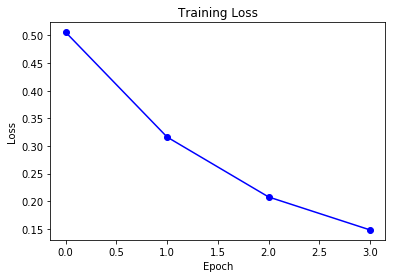

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# test

In [0]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_note', 'sentence'])

print('Number of test sentences: %d\n' % df.shape[0])

sentences = df.sentence.values
labels = df.label.values

input_ids = []

for s in sentences:
    encoded_sent = tokenizer.encode(
        s,
        add_special_tokens=True
    )
    input_ids.append(encoded_sent)
        
add_padding(input_ids)

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)
    
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


model.eval()

predictions = []
true_labels = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print("Done")

Number of test sentences: 516

Done


In [0]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)
